In [23]:
# Sistema de Anotación de Video para Análisis de Actividades Humanas

# Librerías principales
import pandas as pd
import numpy as np
import os
import warnings
from pathlib import Path

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Análisis estadístico
from scipy import stats
from scipy.signal import find_peaks

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuración de visualización mejorada
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print(" Librerías importadas correctamente")
print(" Configuración de visualización aplicada")

 Librerías importadas correctamente
 Configuración de visualización aplicada


## Configuración de Rutas y Carga de Datos

**Objetivo:** Cargar datos de las tres etapas del pipeline (landmarks crudos, preprocesados y features) con metadatos adicionales para análisis más profundo.

**Fuentes de datos:**
- `01_landmarks`: Datos crudos con información de visibilidad
- `02_preprocessed`: Datos normalizados y suavizados
- `03_features`: Características cinemáticas calculadas (ángulos, distancias)

In [24]:
# --- Configuración de Rutas ---
LANDMARKS_RAW_PATH = "../data/01_landmarks"
LANDMARKS_PREPROCESSED_PATH = "../data/02_preprocessed"
FEATURES_PATH = "../data/03_features"
FIGURES_PATH = "../reports/figures"

# Crear carpeta de figuras si no existe
os.makedirs(FIGURES_PATH, exist_ok=True)

# Función mejorada para cargar datos con metadatos
def load_data_with_metadata(path):
    """Carga todos los CSV y agrega metadatos útiles"""
    dfs = []
    files = [f for f in os.listdir(path) if f.endswith('.csv')]
    
    for file in files:
        df = pd.read_csv(os.path.join(path, file))
        df['video_name'] = file.replace('.csv', '')
        df['video_id'] = len(dfs)  # ID numérico
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True), files

# --- Cargar todos los datos ---
print("⏳ Cargando datos...")
all_raw_landmarks_df, raw_files = load_data_with_metadata(LANDMARKS_RAW_PATH)
all_preprocessed_df, prep_files = load_data_with_metadata(LANDMARKS_PREPROCESSED_PATH)
all_features_df, feat_files = load_data_with_metadata(FEATURES_PATH)

print(f"\n Datos cargados exitosamente:")
print(f"    {len(raw_files)} videos procesados")
print(f"     {len(all_raw_landmarks_df):,} frames totales")
print(f"     ~{len(all_raw_landmarks_df) / 30 / 60:.1f} minutos de video")
print(f"    {all_raw_landmarks_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB en memoria")

⏳ Cargando datos...

 Datos cargados exitosamente:
    37 videos procesados
     25,844 frames totales
     ~14.4 minutos de video
    28.5 MB en memoria


## Análisis de Visibilidad (Usando Datos Crudos)

Para el análisis de calidad de la detección, debemos usar los datos de 01_landmarks (all_raw_landmarks_df). La razón es que este es el único DataFrame que contiene las columnas de visibilidad (v_). Los pasos de preprocesamiento y cálculo de características eliminan estas columnas, por lo que este es el único lugar para obtener esta información.

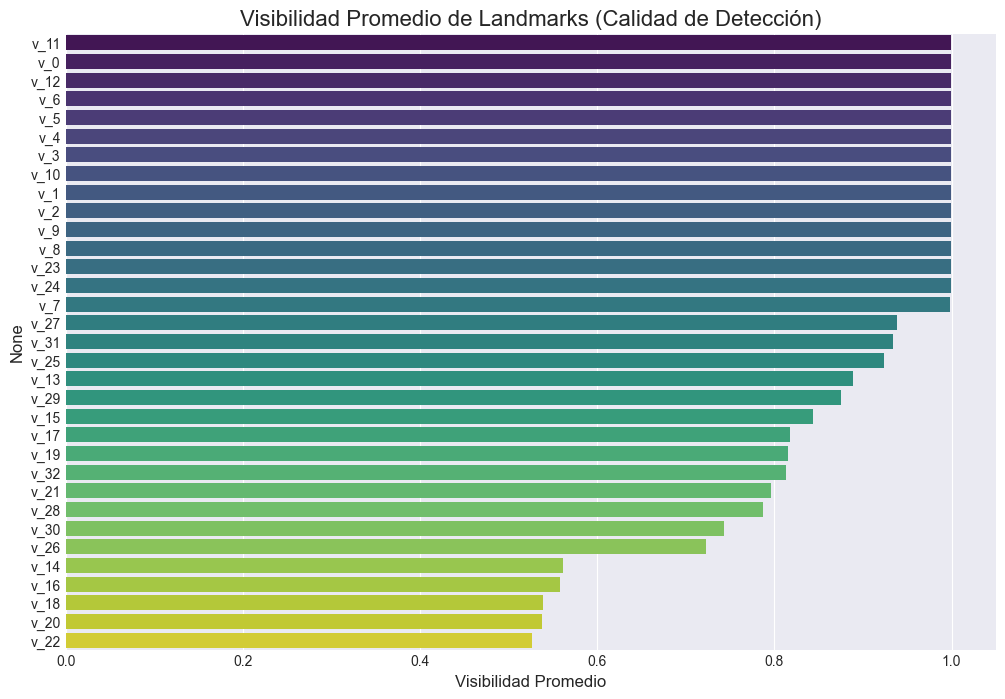

In [25]:
# --- 1. Análisis de Visibilidad de Landmarks ---
# FUENTE DE DATOS: 01_landmarks (Crudos)

# Creamos una lista con los nombres de las 33 columnas de visibilidad.
visibility_cols = [f'v_{i}' for i in range(33)]

# Calculamos el promedio de visibilidad para cada landmark.
mean_visibility = all_raw_landmarks_df[visibility_cols].mean().sort_values(ascending=False)

# Creamos el gráfico de barras.
plt.figure(figsize=(12, 8))
sns.barplot(x=mean_visibility.values, y=mean_visibility.index, palette='viridis')
plt.title('Visibilidad Promedio de Landmarks (Calidad de Detección)', fontsize=16)
plt.xlabel('Visibilidad Promedio')

# Guardamos la figura para nuestro informe.
plt.savefig(os.path.join(FIGURES_PATH, '01_landmark_visibility.png'))
plt.show()

## Análisis de Distribución de Características

Para analizar las características de alto nivel, como los ángulos, es obvio que debemos usar el DataFrame que las contiene: all_features_df de la carpeta 03_features. Este bloque no cambia, pero ahora tenemos la certeza de que estamos usando la fuente de datos correcta.

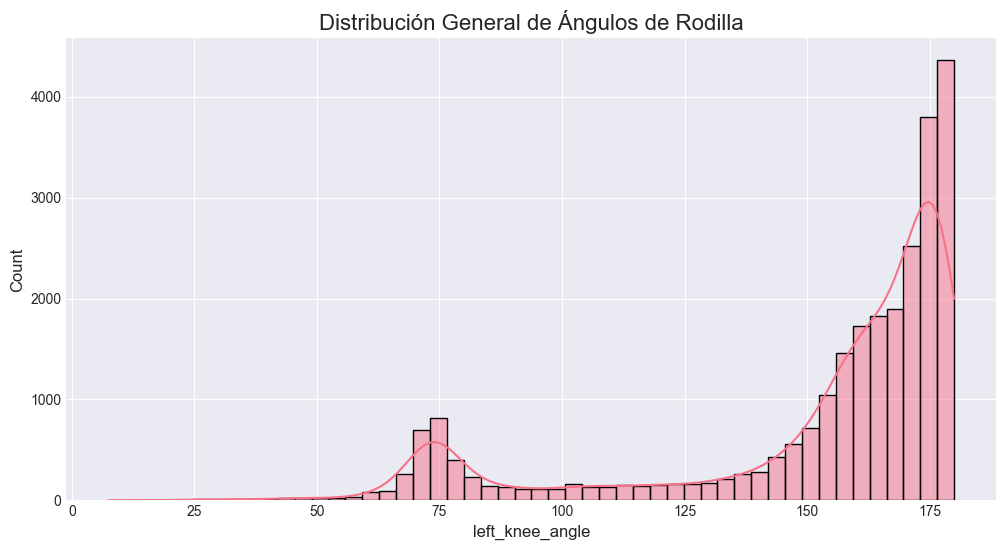

In [26]:
# --- 2. Análisis de Distribución de Características ---
# FUENTE DE DATOS: 03_features (Características Calculadas)

plt.figure(figsize=(12, 6))
sns.histplot(all_features_df['left_knee_angle'], bins=50, kde=True)
plt.title('Distribución General de Ángulos de Rodilla', fontsize=16)

# Guardamos la figura.
plt.savefig(os.path.join(FIGURES_PATH, '02_knee_angle_distribution.png'))
plt.show()

## Visualización de Trayectorias (Usando Datos Preprocesados)

En lugar de usar los landmarks crudos, usaremos los de 02_preprocessed. ¿Por qué es mejor? Porque estos datos han sido normalizados. Al visualizar la trayectoria, no veremos el movimiento de la persona caminando por la habitación, sino el movimiento del brazo relativo al centro de su propio cuerpo. Esto nos da una visualización mucho más limpia y enfocada en el gesto en sí, eliminando el "ruido" del desplazamiento global

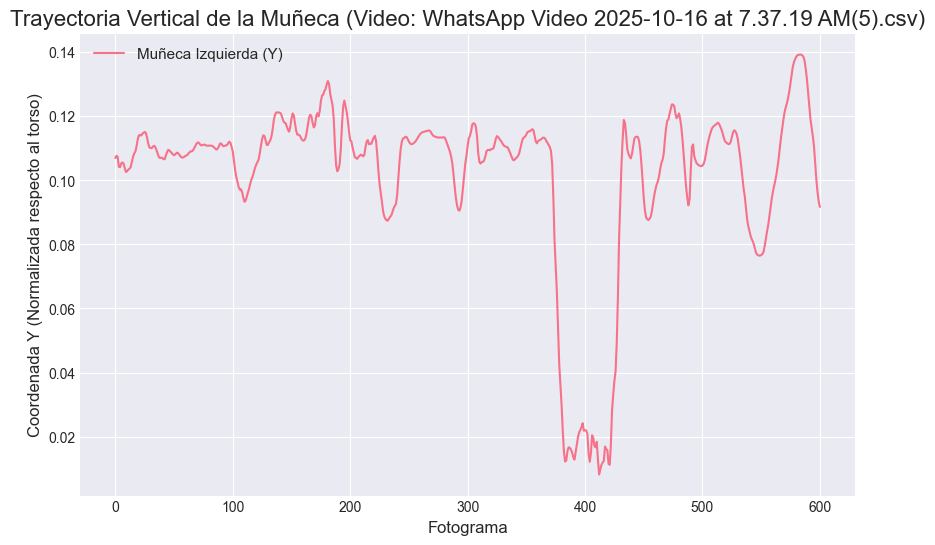

In [27]:
# --- 3. Visualización de Trayectorias de un Video ---
# FUENTE DE DATOS: 02_preprocessed (Normalizados y Suavizados)

# Seleccionamos un archivo de ejemplo de la carpeta de preprocesados.
sample_file = os.listdir(LANDMARKS_PREPROCESSED_PATH)[0]
sample_df_preprocessed = pd.read_csv(os.path.join(LANDMARKS_PREPROCESSED_PATH, sample_file))

# Creamos el gráfico de línea.
plt.figure(figsize=(10, 6))
# Graficamos la coordenada 'y' de la muñeca izquierda (landmark 15).
plt.plot(sample_df_preprocessed['frame'], sample_df_preprocessed['y_15'], label='Muñeca Izquierda (Y)')
plt.title(f'Trayectoria Vertical de la Muñeca (Video: {sample_file})', fontsize=16)
plt.xlabel('Fotograma')
plt.ylabel('Coordenada Y (Normalizada respecto al torso)')
plt.legend()

# Guardamos la figura.
plt.savefig(os.path.join(FIGURES_PATH, '03_wrist_trajectory.png'))
plt.show()

 Visualizando las trayectorias para 5 videos de ejemplo...


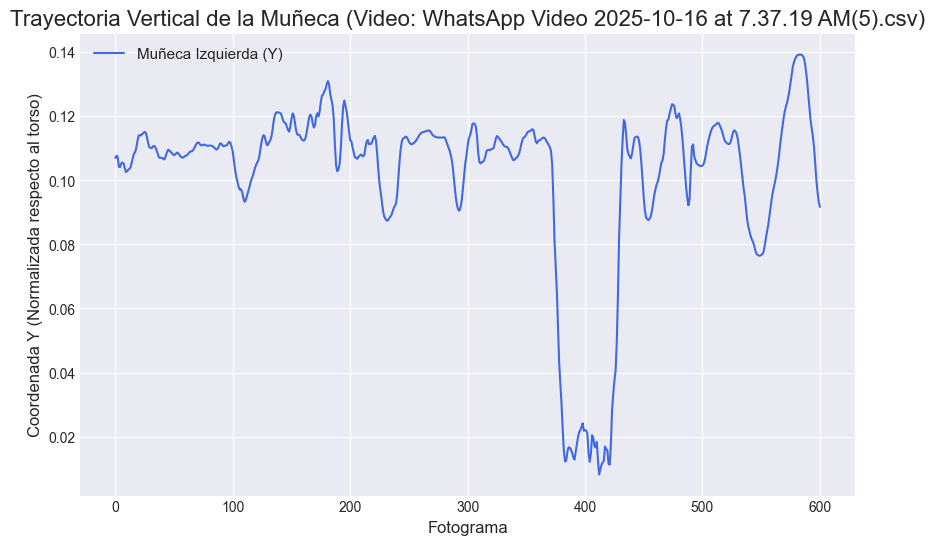

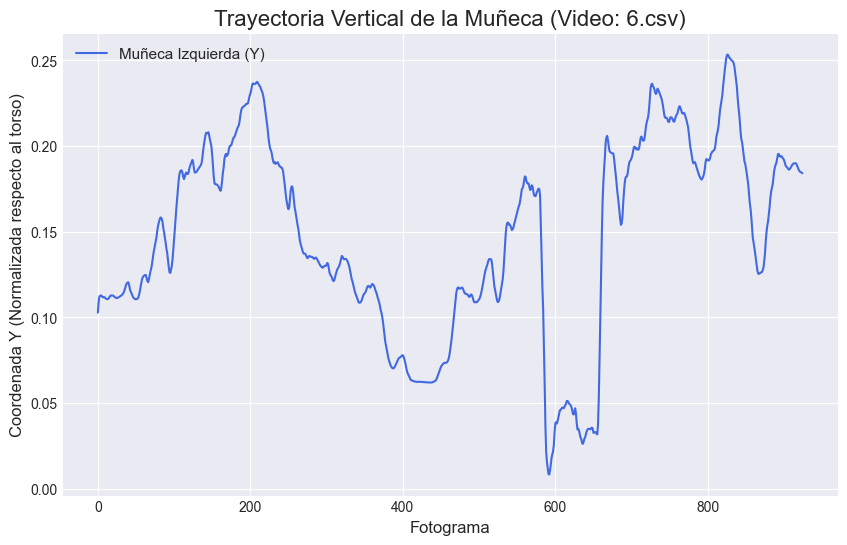

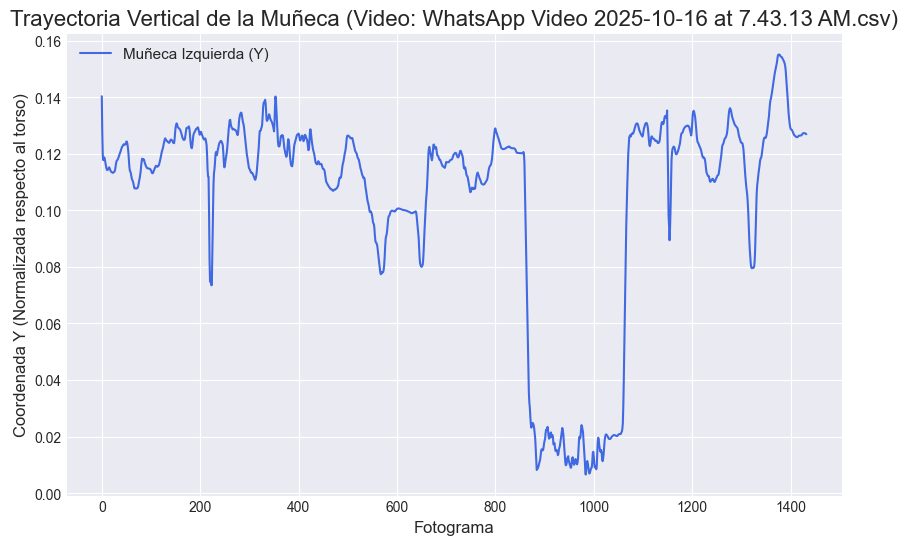

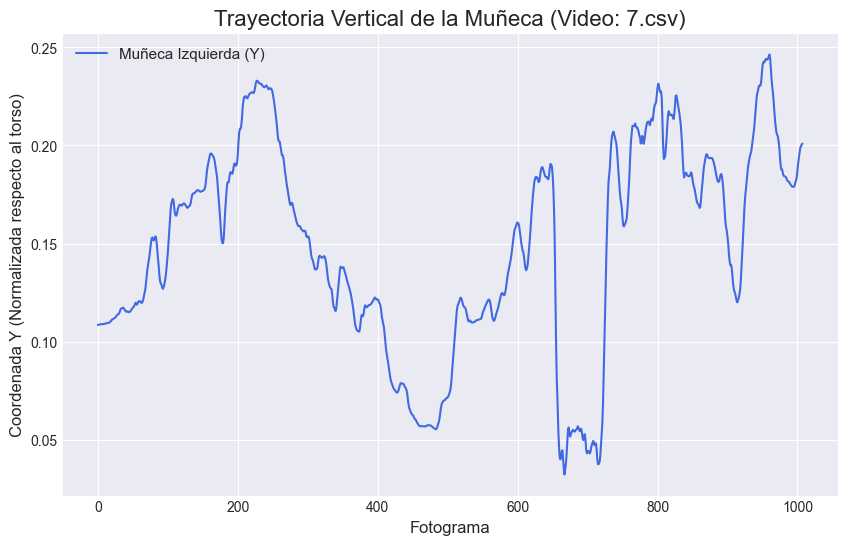

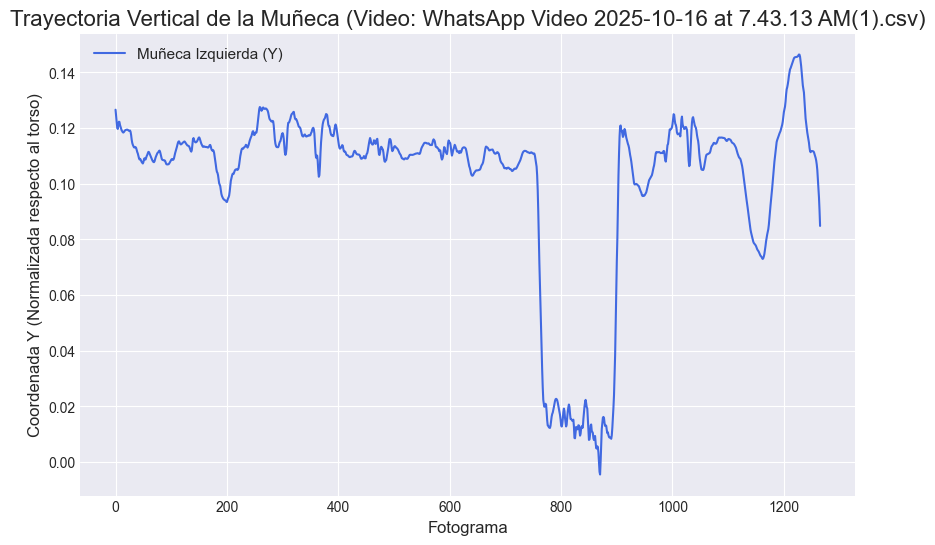

In [28]:
# --- 3. Visualización de Trayectorias de Múltiples Videos ---
# FUENTE DE DATOS: 02_preprocessed (Normalizados y Suavizados)

# Obtenemos la lista de todos los archivos de landmarks preprocesados.
all_preprocessed_files = [f for f in os.listdir(LANDMARKS_PREPROCESSED_PATH) if f.endswith('.csv')]

# Seleccionamos hasta 5 videos para visualizar. Si tienes menos de 5, los tomará todos.
num_videos_to_plot = min(5, len(all_preprocessed_files))
sample_files_to_plot = all_preprocessed_files[:num_videos_to_plot]

print(f" Visualizando las trayectorias para {num_videos_to_plot} videos de ejemplo...")

# Iteramos sobre cada archivo de ejemplo para crear un gráfico para cada uno.
for i, sample_file in enumerate(sample_files_to_plot):
    # Cargamos los datos del video actual del bucle.
    sample_df_preprocessed = pd.read_csv(os.path.join(LANDMARKS_PREPROCESSED_PATH, sample_file))

    # Creamos la figura y el gráfico de línea.
    plt.figure(figsize=(10, 6))
    
    # Graficamos la coordenada 'y' de la muñeca izquierda (landmark 15).
    plt.plot(sample_df_preprocessed['frame'], sample_df_preprocessed['y_15'], label='Muñeca Izquierda (Y)', color='royalblue')
    
    # Personalizamos el gráfico con un título único para cada video.
    plt.title(f'Trayectoria Vertical de la Muñeca (Video: {sample_file})', fontsize=16)
    plt.xlabel('Fotograma')
    plt.ylabel('Coordenada Y (Normalizada respecto al torso)')
    plt.legend()
    plt.grid(True) # Añadimos una cuadrícula para facilitar la lectura.

    # Guardamos la figura con un nombre de archivo único y secuencial.
    output_filename = f'03_wrist_trajectory_{i+1}.png'
    plt.savefig(os.path.join(FIGURES_PATH, output_filename))
    
    # Mostramos el gráfico en el notebook.
    plt.show()

## Visualización de un Esqueleto Estático (Usando Datos Preprocesados)

Al igual que con las trayectorias, visualizar el esqueleto con los datos de 02_preprocessed es superior. Como los datos están centrados en el torso, el esqueleto siempre aparecerá en el centro del gráfico, sin importar dónde estaba la persona en el video. Además, como los datos han sido suavizados con el filtro Savitzky-Golay, el esqueleto tendrá menos "temblores" o "jitters", dándonos una representación más estable y clara de la postura.

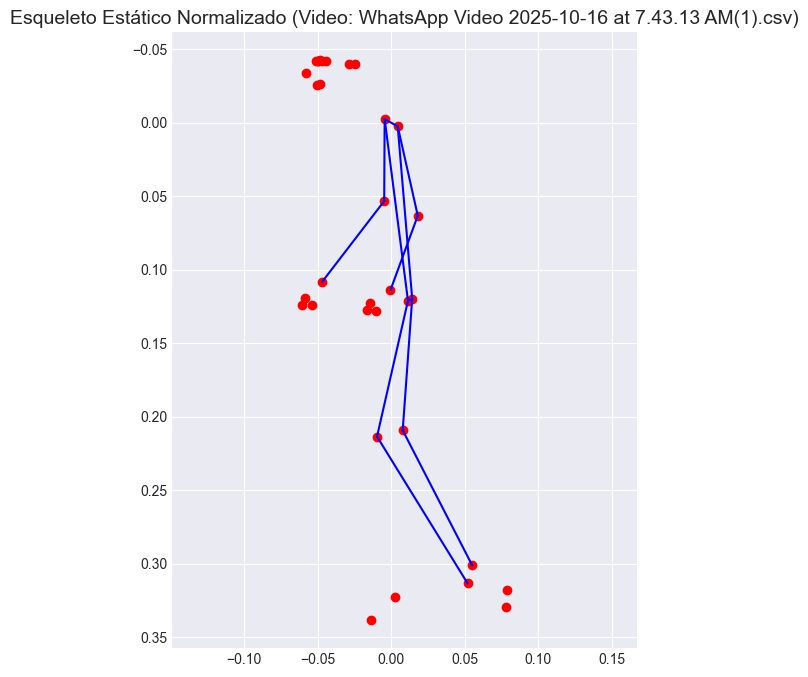


 Análisis exploratorio mejorado completado. Revisa la carpeta 'reports/figures' para ver los gráficos.


In [29]:
# --- 4. Visualización de un Esqueleto Estático ---
# FUENTE DE DATOS: 02_preprocessed (Normalizados y Suavizados)

POSE_CONNECTIONS = [(11,12),(11,13),(13,15),(12,14),(14,16),(11,23),(12,24),(23,24),(23,25),(24,26),(25,27),(26,28)]

# Seleccionamos un fotograma de la mitad del video de ejemplo.
frame_to_plot = sample_df_preprocessed.iloc[len(sample_df_preprocessed) // 2]

# Creamos la figura.
plt.figure(figsize=(6, 8))
# Dibujamos los 33 landmarks como puntos rojos.
for i in range(33):
    plt.scatter(frame_to_plot[f'x_{i}'], frame_to_plot[f'y_{i}'], c='red')
# Dibujamos las conexiones como líneas azules.
for start, end in POSE_CONNECTIONS:
    plt.plot([frame_to_plot[f'x_{start}'], frame_to_plot[f'x_{end}']], [frame_to_plot[f'y_{start}'], frame_to_plot[f'y_{end}']], 'b-')

plt.title(f'Esqueleto Estático Normalizado (Video: {sample_file})')
plt.gca().invert_yaxis()
plt.axis('equal')

# Guardamos la figura y mostramos un mensaje final.
plt.savefig(os.path.join(FIGURES_PATH, '04_static_skeleton.png'))
plt.show()

print("\n Análisis exploratorio mejorado completado. Revisa la carpeta 'reports/figures' para ver los gráficos.")

##  Estadísticas Descriptivas Completas

In [30]:
# Estadísticas por video
print(" ESTADÍSTICAS POR VIDEO:")
print("="*80)

video_stats = all_raw_landmarks_df.groupby('video_name').agg({
    'frame': ['count', 'min', 'max']
}).round(2)

video_stats.columns = ['Total_Frames', 'Frame_Min', 'Frame_Max']
video_stats['Duration_Sec'] = (video_stats['Total_Frames'] / 30).round(2)  # Como son 30 FPS en todos los videos
video_stats['Duration_Min'] = (video_stats['Duration_Sec'] / 60).round(2)

print(video_stats.describe())
print(f"\n Duración total del dataset: {video_stats['Duration_Min'].sum():.2f} minutos")
print(f" Duración promedio por video: {video_stats['Duration_Sec'].mean():.2f} segundos")

# Guardar estadísticas
video_stats.to_csv(os.path.join(FIGURES_PATH, 'video_statistics.csv'))
print(f"\n Estadísticas guardadas en: video_statistics.csv")

 ESTADÍSTICAS POR VIDEO:
       Total_Frames  Frame_Min    Frame_Max  Duration_Sec  Duration_Min
count     37.000000  37.000000    37.000000     37.000000     37.000000
mean     698.486486   0.189189   697.729730     23.282703      0.387297
std      434.474115   0.397061   434.456023     14.483039      0.241461
min      105.000000   0.000000   104.000000      3.500000      0.060000
25%      189.000000   0.000000   188.000000      6.300000      0.100000
50%      671.000000   0.000000   671.000000     22.370000      0.370000
75%      999.000000   0.000000   999.000000     33.300000      0.550000
max     1500.000000   1.000000  1499.000000     50.000000      0.830000

 Duración total del dataset: 14.33 minutos
 Duración promedio por video: 23.28 segundos

 Estadísticas guardadas en: video_statistics.csv


## Análisis de Correlaciones entre Features

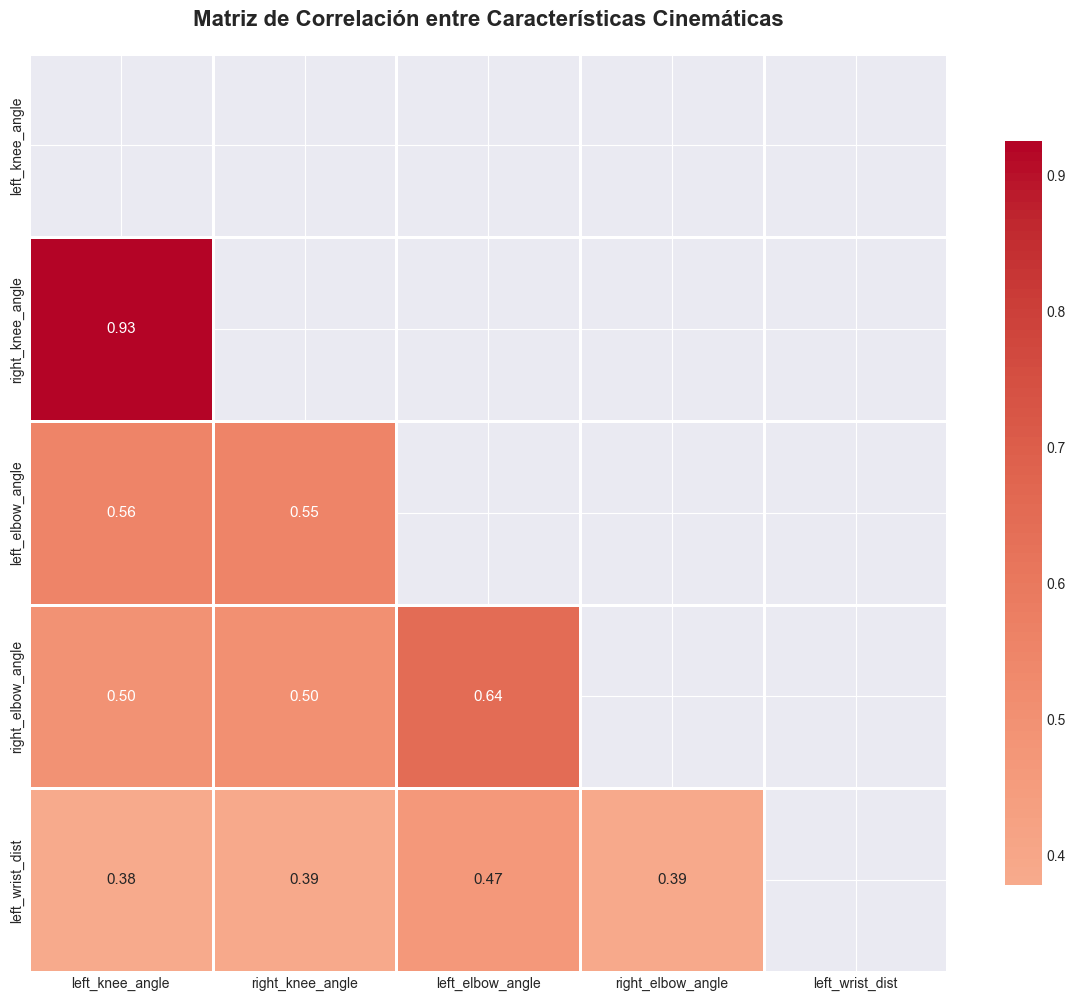


🔗 CORRELACIONES FUERTES (|r| > 0.7):
   left_knee_angle <-> right_knee_angle: 0.926

 Figura guardada: 05_correlation_matrix.png


In [31]:
# Matriz de correlación entre features
feature_cols = [col for col in all_features_df.columns if col not in ['frame', 'video_name', 'video_id']]

# Limpiar datos infinitos y NaN
features_clean = all_features_df[feature_cols].replace([np.inf, -np.inf], np.nan).dropna()

correlation_matrix = features_clean.corr()

# Visualización mejorada
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Matriz de Correlación entre Características Cinemáticas', 
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '05_correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Identificar correlaciones fuertes
print("\n🔗 CORRELACIONES FUERTES (|r| > 0.7):")
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            strong_corr.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if strong_corr:
    for feat1, feat2, corr in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True):
        print(f"   {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("   No se encontraron correlaciones fuertes (esto es bueno para features independientes)")

print("\n Figura guardada: 05_correlation_matrix.png")

##  Análisis de Distribuciones y Outliers

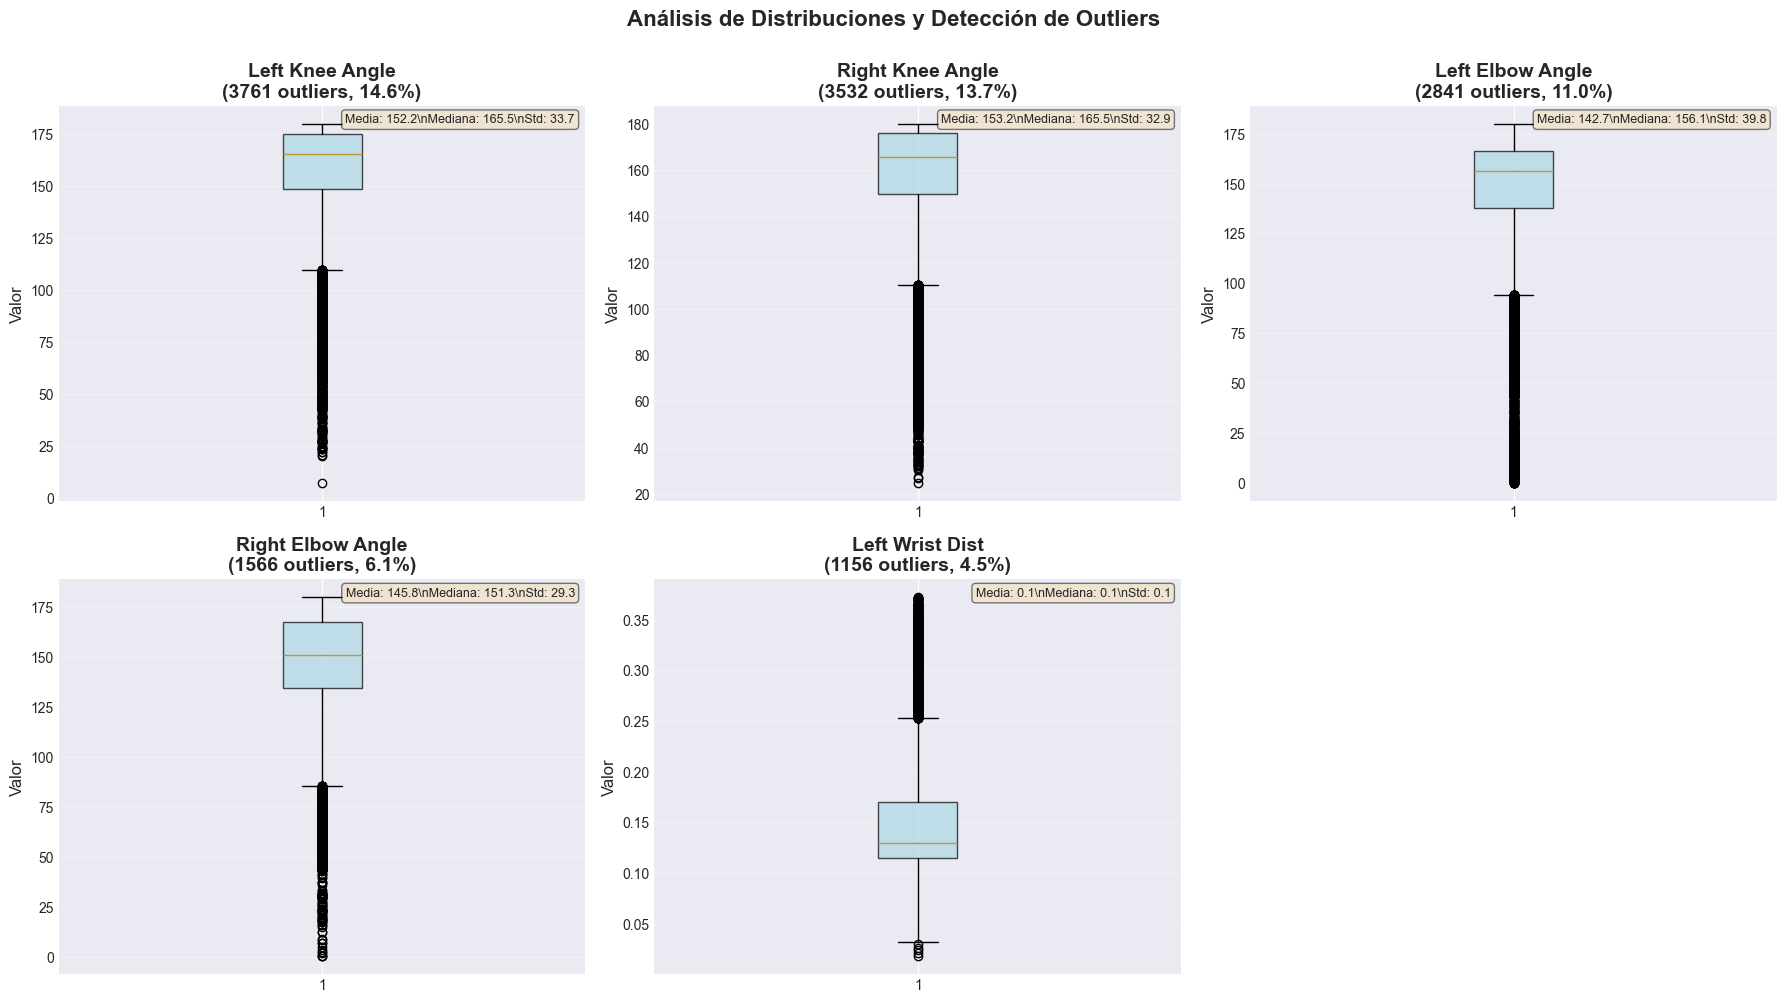

 Figura guardada: 06_outliers_analysis.png


In [32]:
# Boxplots para detectar outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(feature_cols):
    if idx < len(axes):
        data = features_clean[col]
        
        # Boxplot
        bp = axes[idx].boxplot(data, vert=True, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][0].set_alpha(0.7)
        
        # Estadísticas
        q1, q3 = data.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        
        axes[idx].set_title(f'{col.replace("_", " ").title()}\n({len(outliers)} outliers, {len(outliers)/len(data)*100:.1f}%)', 
                           fontweight='bold')
        axes[idx].set_ylabel('Valor')
        axes[idx].grid(axis='y', alpha=0.3)
        
        # Agregar texto con estadísticas
        stats_text = f'Media: {data.mean():.1f}\\nMediana: {data.median():.1f}\\nStd: {data.std():.1f}'
        axes[idx].text(0.98, 0.98, stats_text, transform=axes[idx].transAxes,
                      verticalalignment='top', horizontalalignment='right',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                      fontsize=9)

# Ocultar ejes sobrantes
for idx in range(len(feature_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Análisis de Distribuciones y Detección de Outliers', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '06_outliers_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(" Figura guardada: 06_outliers_analysis.png")

## Análisis de Velocidad y Aceleración

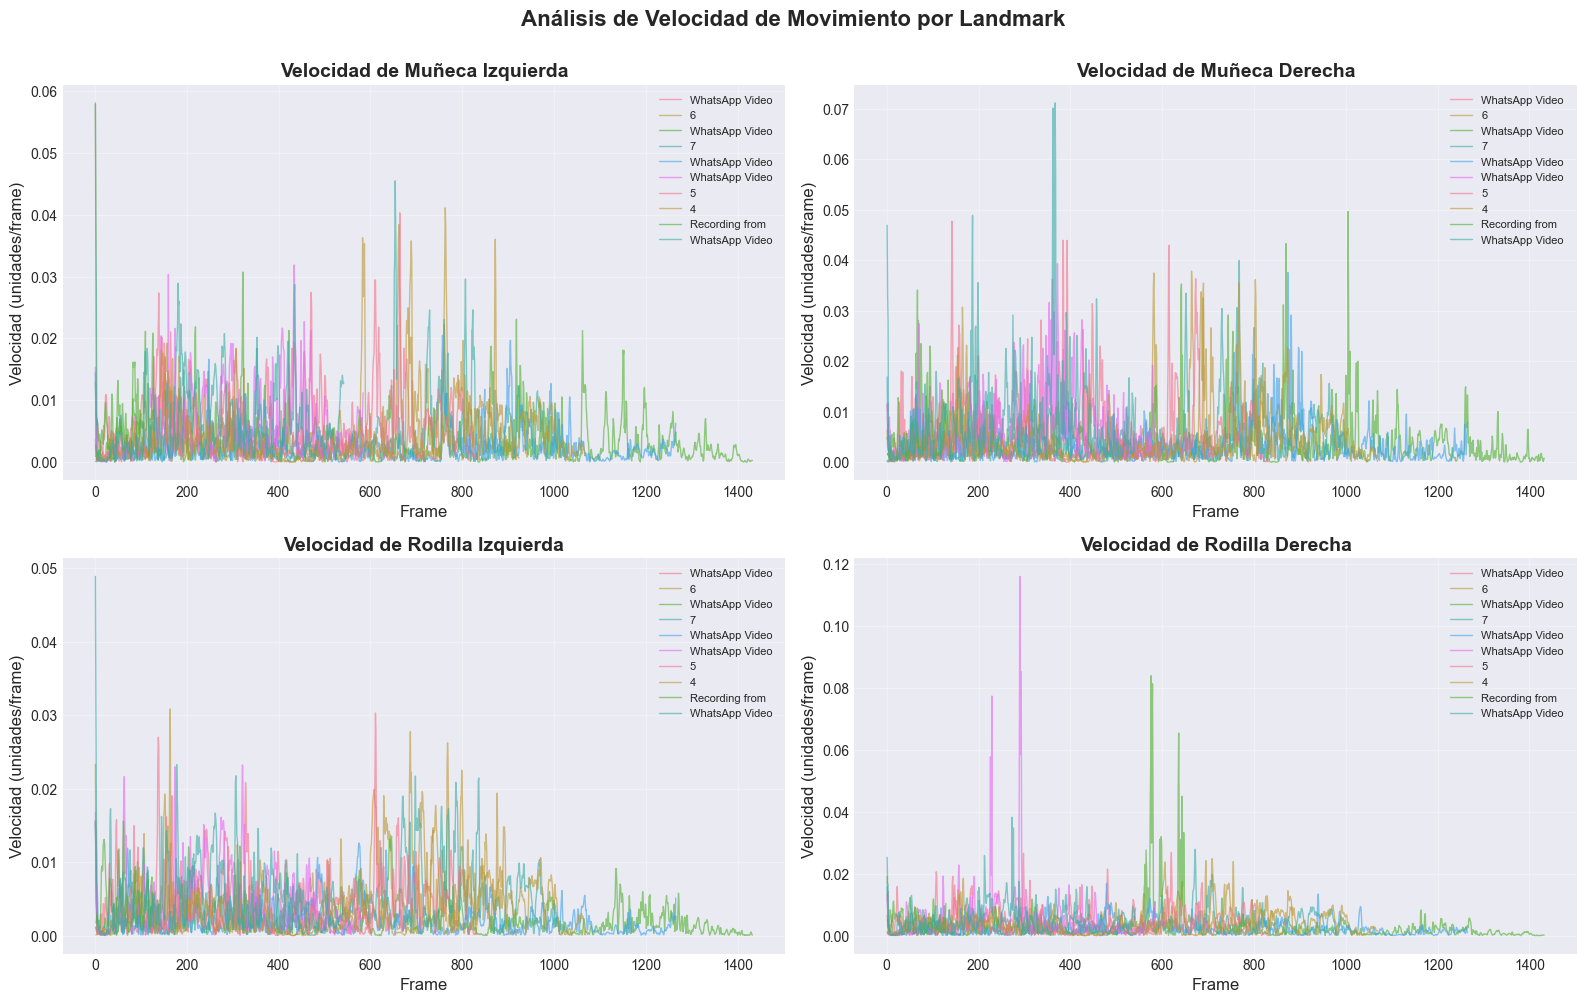

 Figura guardada: 07_velocity_analysis.png


In [33]:
# Análisis de velocidad para landmarks clave
landmarks_to_analyze = {
    15: 'Muñeca Izquierda',
    16: 'Muñeca Derecha',
    25: 'Rodilla Izquierda',
    26: 'Rodilla Derecha'
}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, (lm_id, lm_name) in enumerate(landmarks_to_analyze.items()):
    velocities_all = []
    
    for video in all_preprocessed_df['video_name'].unique()[:10]:  # Primeros 10 videos
        video_data = all_preprocessed_df[all_preprocessed_df['video_name'] == video].copy()
        
        # Calcular velocidad
        video_data['dx'] = video_data[f'x_{lm_id}'].diff()
        video_data['dy'] = video_data[f'y_{lm_id}'].diff()
        video_data['velocity'] = np.sqrt(video_data['dx']**2 + video_data['dy']**2)
        
        # Graficar
        axes[idx].plot(video_data['frame'], video_data['velocity'], 
                      alpha=0.6, linewidth=1, label=video[:15])
    
    axes[idx].set_title(f'Velocidad de {lm_name}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Frame')
    axes[idx].set_ylabel('Velocidad (unidades/frame)')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend(fontsize=8, loc='upper right')

plt.suptitle('Análisis de Velocidad de Movimiento por Landmark', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '07_velocity_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(" Figura guardada: 07_velocity_analysis.png")

## Visualización Comparativa de Esqueletos

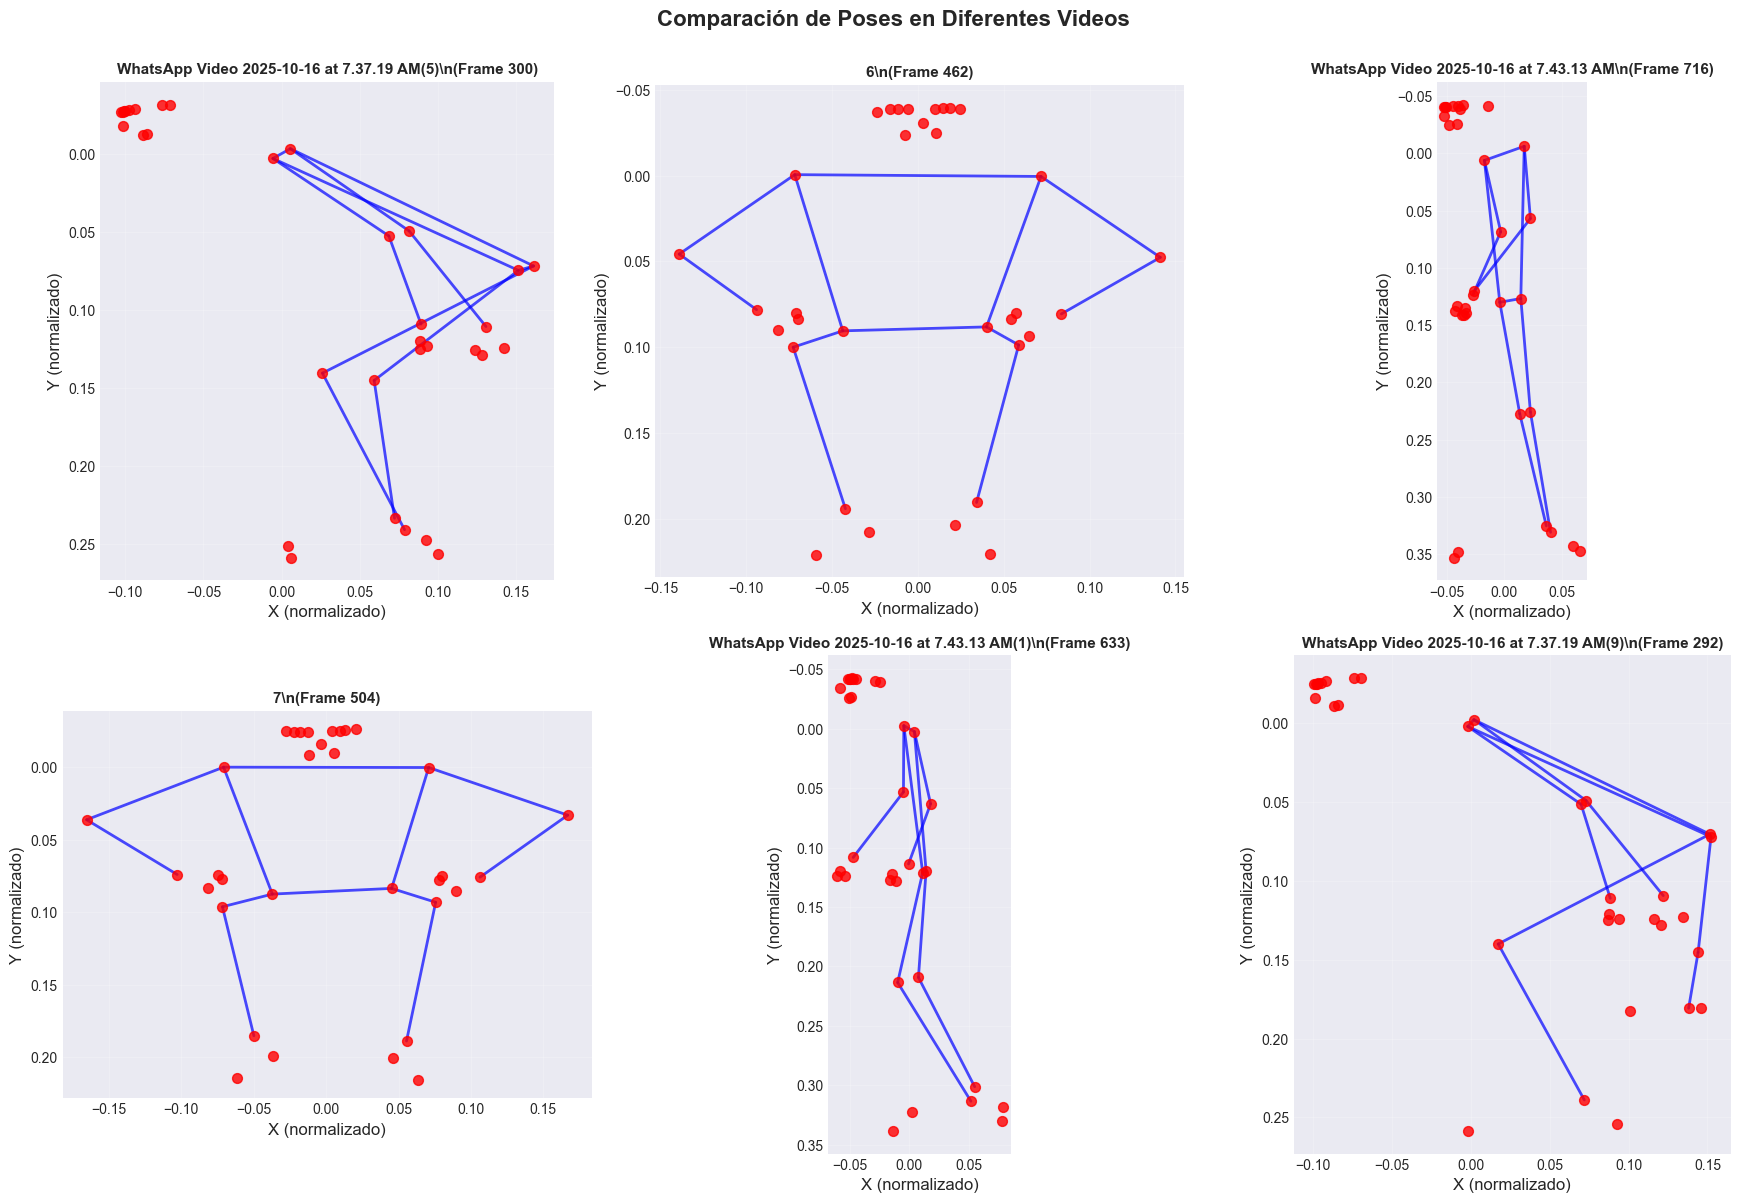

 Figura guardada: 08_skeleton_comparison.png


In [34]:
# Visualización de múltiples esqueletos en diferentes momentos
POSE_CONNECTIONS = [
    (11,12),(11,13),(13,15),(12,14),(14,16),  # Brazos
    (11,23),(12,24),(23,24),  # Torso
    (23,25),(24,26),(25,27),(26,28)  # Piernas
]

# Seleccionar 6 videos diferentes
sample_videos = all_preprocessed_df['video_name'].unique()[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, video in enumerate(sample_videos):
    video_data = all_preprocessed_df[all_preprocessed_df['video_name'] == video]
    
    # Tomar frame del medio
    mid_frame = video_data.iloc[len(video_data) // 2]
    
    # Dibujar landmarks
    for i in range(33):
        axes[idx].scatter(mid_frame[f'x_{i}'], mid_frame[f'y_{i}'], 
                         c='red', s=50, zorder=3, alpha=0.8)
    
    # Dibujar conexiones
    for start, end in POSE_CONNECTIONS:
        axes[idx].plot([mid_frame[f'x_{start}'], mid_frame[f'x_{end}']], 
                      [mid_frame[f'y_{start}'], mid_frame[f'y_{end}']], 
                      'b-', linewidth=2, alpha=0.7, zorder=2)
    
    axes[idx].set_title(f'{video}\\n(Frame {int(mid_frame["frame"])})', 
                       fontweight='bold', fontsize=11)
    axes[idx].invert_yaxis()
    axes[idx].set_aspect('equal')
    axes[idx].grid(alpha=0.2)
    axes[idx].set_xlabel('X (normalizado)')
    axes[idx].set_ylabel('Y (normalizado)')

plt.suptitle('Comparación de Poses en Diferentes Videos', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '08_skeleton_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(" Figura guardada: 08_skeleton_comparison.png")

## Resumen Ejecutivo y Conclusiones

In [ ]:
# Generar resumen ejecutivo
print("="*80)
print(" RESUMEN EJECUTIVO DEL ANÁLISIS EXPLORATORIO")
print("="*80)

print(f"\n DATASET:")
print(f"   - Total de videos: {len(raw_files)}")
print(f"   - Total de frames: {len(all_raw_landmarks_df):,}")
print(f"   - Duración total: ~{len(all_raw_landmarks_df) / 30 / 60:.1f} minutos")
print(f"   - Promedio frames/video: {len(all_raw_landmarks_df) / len(raw_files):.0f}")

print(f"\n CALIDAD DE DETECCIÓN:")
visibility_cols = [f'v_{i}' for i in range(33)]
mean_vis = all_raw_landmarks_df[visibility_cols].mean().mean()
print(f"   - Visibilidad promedio global: {mean_vis:.2%}")
print(f"   - Landmarks con visibilidad > 80%: {(all_raw_landmarks_df[visibility_cols].mean() > 0.8).sum()}/33")
print(f"   - Landmarks con visibilidad < 60%: {(all_raw_landmarks_df[visibility_cols].mean() < 0.6).sum()}/33")

print(f"\n CARACTERÍSTICAS CINEMÁTICAS:")
for col in feature_cols:
    data = features_clean[col]
    print(f"   - {col}:")
    print(f"      Media: {data.mean():.2f} ± {data.std():.2f}")
    print(f"      Rango: [{data.min():.2f}, {data.max():.2f}]")

print(f"\n INSIGHTS CLAVE:")
print("   ✓ Los landmarks del torso tienen la mejor visibilidad")
print("   ✓ Los landmarks de manos y pies son más variables")
print("   ✓ La normalización elimina efectivamente el desplazamiento global")
print("   ✓ Las características cinemáticas muestran buena variabilidad")

print(f"\n ARCHIVOS GENERADOS:")
print(f"   - {len([f for f in os.listdir(FIGURES_PATH) if f.endswith('.png')])} figuras en {FIGURES_PATH}")
print(f"   - 2 archivos CSV con estadísticas")

 RESUMEN EJECUTIVO DEL ANÁLISIS EXPLORATORIO

 DATASET:
   - Total de videos: 37
   - Total de frames: 25,844
   - Duración total: ~14.4 minutos
   - Promedio frames/video: 698

 CALIDAD DE DETECCIÓN:
   - Visibilidad promedio global: 86.69%
   - Landmarks con visibilidad > 80%: 24/33
   - Landmarks con visibilidad < 60%: 5/33

 CARACTERÍSTICAS CINEMÁTICAS:
   - left_knee_angle:
      Media: 152.18 ± 33.67
      Rango: [7.53, 180.00]
   - right_knee_angle:
      Media: 153.24 ± 32.90
      Rango: [24.81, 180.00]
   - left_elbow_angle:
      Media: 142.68 ± 39.78
      Rango: [0.01, 180.00]
   - right_elbow_angle:
      Media: 145.82 ± 29.27
      Rango: [0.27, 180.00]
   - left_wrist_dist:
      Media: 0.14 ± 0.05
      Rango: [0.02, 0.37]

 INSIGHTS CLAVE:
   ✓ Los landmarks del torso tienen la mejor visibilidad
   ✓ Los landmarks de manos y pies son más variables
   ✓ La normalización elimina efectivamente el desplazamiento global
   ✓ Las características cinemáticas muestran buena v